In [1]:
import pandas as pd
import geopandas as gpd
import os
import re
import matplotlib.pyplot as plt
print(os.getcwd())
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())
pd.set_option('display.max_columns', None)

c:\Users\LMENENDEZ\GitHub\MultiModX\notebooks
C:\Users\LMENENDEZ\GitHub\MultiModX


NOTE: I might want to remove the legs column in the future 

Some characteristics of the trips that go abroad:
- if the person is spanish: we know the "roaming out", i.e., the signal they emitted when they connect to roaming. Hence we know with certainty the country where they arrived. However, if they did a connection, we only know the country where they first connected. We have to assume that that is their final destination
- if the person is not spanish, we assume their country of destination is their origin country. 
For trips that come from abroad a similar situation holds

This might create inaccuracies in the results


# 1. Format and eliminate unnecessary trips

In [2]:
# Trips during the week 22/09/2022 28/09/2022 (thursday to thursday)
# the day of study selected was Friday to put the air layer under pressure
all_trips = pd.read_csv(
    r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\Matrices MITMA\with_archetypes\20220922_28_trip_matrix_arc_pt_processed.csv.gz",
    compression="gzip",
    sep="|"
)

In [3]:
#Here there is no trip id but later trip id appears all the time
trips = all_trips[all_trips["date"] == 20220923].reset_index(drop=True).rename(columns={"origin_nut": "origin", "destination_nut": "destination"})
trips.head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced
0,20220923,P00,01002,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,NF,O,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*01002*01002*None*train_13121*00-01*road*No...,other,ES,2_48,4801303,2_48,I01_[10000-15000),A01_[25-45),male,passenger,False,4.135,139.516,1.0,0.000000,0.000000,2.067500,2.067500,0.000000,0.000000,3,road-train-road,train_13121-train_13200,train_13121,train_13200,national,2,1,0,train_13121-train_13200,train_13106,train_13200
1,20220923,P00,01009_AM,ES211,Álava,31010_AM,ES220,Navarra,NaN,NaN,O,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,ES,2_31,31010_AM,2_31,I01_[10000-15000),A01_[25-45),male,passenger,False,5.191,69.312,1.0,3.707857,0.000000,0.000000,0.494381,0.000000,0.988762,3,road-train-road,train_11213-train_11300,train_11213,train_11300,national,2,1,0,train_11213-train_11300,train_13106,train_11300
2,20220923,P00,01009_AM,ES211,Álava,abroad_208,abroad,abroad,NaN,ground_Fra_08,NF,NF,abroad,D05_[50000-inf),01-02,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,FR,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,1.599,309.588,1.0,0.888333,0.399750,0.142133,0.071067,0.062183,0.035533,3,road-train-road,train_11213-train_11600,train_11213,train_11600,international_D,2,1,0,train_11213-train_11600,train_11208,train_11511
3,20220923,P00,01036,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,H,O,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01036*01036*None*train_13106*00-01*road*No...,other,ES,2_01,01036,2_48,I02_[15000-inf),A02_[45-65),female,passenger,False,6.236,139.477,1.0,3.118000,0.000000,0.779500,1.559000,0.779500,0.000000,3,road-train-road,train_13106-train_13200,train_13106,train_13200,national,2,1,0,train_13106-train_13200,train_13106,train_13200
4,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,O,NF,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_01,0105904,2_01,I02_[15000-inf),A02_[45-65),male,passenger,False,4.215,155.813,1.0,3.417568,0.113919,0.227838,0.227838,0.227838,0.000000,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200


In [4]:
%load_ext autoreload

In [5]:
%autoreload
from script.trips_format import *

In [6]:
#associates each airport to the corresponding new NUTS
airports_to_NUTS={"airport_LPA":("ES705","Gran Canaria"),
                 "airport_FUE":("ES704","Fuerteventura"),
                 "airport_ACE":("ES708","Lanzarote"),
                 "airport_TFS":("ES709","Tenerife"),
                 "airport_TFN":("ES709","Tenerife"),
                 "airport_GMZ":("ES709","Tenerife"),
                 "airport_SPC":("ES707","La Palma"),
                 "airport_VDE":("ES703","El Hierro"),
                 "airport_PMI":("ES532","Mallorca"),
                 "airport_IBZ":("ES531","Eivissa i Formentera"),
                 "airport_MAH":("ES533","Menorca")}

In [7]:
trips=format_trips(trips,airports_to_NUTS)

17 columns were removed


First we remove the cercanías trips and the trips that go through weird stations

In [8]:
# remove cercanías
trips=trips[~(((trips["origin"]=="ES424")&(trips["destination"]=="ES300"))|((trips["origin"]=="ES300")&(trips["destination"]=="ES424")))]

In [9]:
# location of "ALL" train stops given by UiC
# However this list is still incomplete
stops_loc=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\rail_info\stops.txt").astype(str) # everything is a string here to match other formatting
stops_loc["stop_id"] = stops_loc["stop_id"].apply(lambda x: "00" + x) #to make they start with 00

In [10]:
trips.loc[:,"weird_stations"] = trips["node_sequence_reduced"].apply(
    lambda x: find_weird_stations(x, stops_loc))

In [11]:
unique_weird_stations=get_weird_stations(trips["weird_stations"])

In [12]:
len(unique_weird_stations)

414

In [13]:
MobA_stations_coord=gpd.read_file(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\oferta_transporte\train_stations\train_stations.shp")

In [14]:
# identifies all the un-localisable stations
nowhere_stations=set(unique_weird_stations)-set(MobA_stations_coord["ID"])
print(f"there are {len(nowhere_stations)} stations that are not in the data provided by MobA but appear in the trips dataframe")

there are 205 stations that are not in the data provided by MobA but appear in the trips dataframe


In [15]:
trips = trips[~trips["node_sequence_reduced"].apply(lambda x: any(station in x for station in nowhere_stations))]

Then we add the relevant information for international trips

In [16]:
international_codes=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\countries mcc\mcc_to_nationality.txt", sep="|")
international_codes

,mcc,country_name,country
0,202,Greece,GR
1,204,Netherlands,NL
2,206,Belgium,BE
3,208,France,FR
4,212,Monaco,MC
...,...,...,...
227,746,Suriname,SR
228,748,Uruguay,UY
229,750,Falkland Islands (Malvinas),FK
230,901,International & Satellite Networks,-


In [17]:
mcc_to_country=international_codes.set_index("mcc")["country"].to_dict()

In [18]:
#it is better to divide trips into trips that go to or come from abroad and trips that do not come from
#or go to abroad to save time in computations

trips_abroad=trips[(trips["origin"]=="abroad")|(trips["destination"]=="abroad")]
trips_national=trips[~((trips["origin"]=="abroad")|(trips["destination"]=="abroad"))]

In [19]:
trips_abroad.shape[0]

77400

In [20]:
trips_abroad[trips_abroad["entry_point"].str.startswith("ground",na=False)]

,date,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips,weird_stations
183059,20220923,FR101,abroad,abroad,08033,ES511,Barcelona,ground_Fra_01,NaN,NF,H,P21*FR101*17223_AM*None*train_79311*00-01*road...,ES,0.732300,0.822024,0.588479,0.044862,0.098960,0.059376,3,road-train-road,train_79311-train_79100,train_79311,train_79100,international_O,2,1,0,train_79311-train_79100,train_79300,train_71801,['rail'],2.346,[]
188369,20220923,FR105,abroad,abroad,20036,ES212,Guipúzcoa,ground_Fra_08,NaN,NF,H,P16*FR105*2006906*None*train_2590*00-01*road*N...,ES,0.483023,0.252326,0.284767,0.003605,0.039651,0.021628,3,road-train-road,train_2590-train_2649,train_2590,train_2649,international_O,2,1,0,train_2590-train_2649,abroad,train_11511,['rail'],1.085,"[train_2590, train_2649]"
188375,20220923,FR105,abroad,abroad,2006905,ES212,Guipúzcoa,ground_Fra_08,NaN,NF,NF,P09*FR105*2004503*None*train_11600*00-01*road*...,ES,0.568500,0.468176,0.412441,0.000000,0.066882,0.000000,3,road-train-road,train_11600-train_11512,train_11600,train_11512,international_O,2,1,0,train_11600,train_11511,train_11511,['rail'],1.516,[]
188618,20220923,FR105,abroad,abroad,31078_AM,ES220,Navarra,ground_Fra_08,NaN,NF,O,P15*FR105*2006904*None*train_11511*00-01*road*...,ES,1.492837,0.682440,0.511830,0.063979,0.170610,0.085305,3,road-train-road,train_11511-train_81202,train_11511,train_81202,international_O,2,1,0,train_11511-train_81202,train_11511,train_81202,['rail'],3.007,[]
189604,20220923,FR107,abroad,abroad,2004503,ES212,Guipúzcoa,ground_Fra_08,NaN,NF,H,P14*FR107*2006903*None*train_2608*00-01*road*N...,ES,0.555000,0.457059,0.402647,0.000000,0.065294,0.000000,3,road-train-road,train_2608-train_2589,train_2608,train_2589,international_O,2,1,0,train_2608-train_2589,abroad,train_11511,['rail'],1.480,"[train_2608, train_2589]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226268,20220923,abroad_643,abroad,abroad,2807901,ES300,Madrid,ground_Por_05,NaN,NF,NF,P17*abroad_643*2807905*None*train_17000*04-06*...,AR,2.200508,0.555165,0.660959,0.027204,0.123930,0.031234,3,road-train-road,train_17000-train_35001,train_17000,train_35001,international_O,2,1,0,train_17000,train_17000,train_17000,['rail'],3.599,[]
226292,20220923,abroad_647,abroad,abroad,2006902,ES212,Guipúzcoa,ground_Fra_08,NaN,NF,NF,P10*abroad_647*2004504*None*train_2632*00-01*r...,FR,0.720117,0.473463,0.331707,0.022681,0.042527,0.008505,3,road-train-road,train_2632-train_2581,train_2632,train_2581,international_O,2,1,0,train_2632-train_2581,abroad,train_11511,['rail'],1.599,"[train_2632, train_2581]"
226306,20220923,abroad_655,abroad,abroad,0310203,ES521,Alicante / Alacant,ground_Por_00,NaN,NF,NF,P15*abroad_655*3205405*None*train_22100*00-01*...,AR,0.992828,2.109759,0.496414,0.000000,0.000000,0.000000,3,road-train-road,train_22100-train_60600,train_22100,train_60600,international_O,2,1,0,train_22100-train_60600,train_22100,train_60600,['rail'],3.599,[]
226376,20220923,abroad_722,abroad,abroad,0801910,ES511,Barcelona,ground_Fra_01,NaN,NF,NF,P18*abroad_722*17223_AM*None*train_79311*00-01...,AR,1.372793,1.028286,0.975929,0.048168,0.104713,0.069111,3,road-train-road,train_79311-train_71802,train_79311,train_71802,international_O,2,1,0,train_79311-train_71802,train_79300,train_71801,['rail'],3.599,[]


In [21]:
trips_abroad=format_trips_abroad(trips_abroad,mcc_to_country)

In [22]:
trips_national=format_trips_national(trips_national)

In [23]:
trips=pd.concat([trips_national,trips_abroad])

In [24]:
trips.head()

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
0,20220923,ES111,A Coruña,ES112,Lugo,NaN,NaN,H,NF,P06*15009*1501702*None*train_20402*00-01*road*...,ES,3.937095,0.051465,0.141530,0.424589,0.257326,0.192995,3,road-train-road,train_20402-train_20309,train_20402,train_20309,national,2,1,0,train_20402-train_20309,train_31400,train_20300,['rail'],5.005
1,20220923,ES111,A Coruña,ES112,Lugo,NaN,NaN,H,NF,P07*15005*1503009*None*train_20410*00-01*road*...,ES,3.351054,0.043805,0.120463,0.361388,0.219023,0.164267,3,road-train-road,train_20410-train_20309,train_20410,train_20309,national,2,1,0,train_20410-train_20309,train_31400,train_20300,['rail'],4.260
2,20220923,ES111,A Coruña,ES112,Lugo,NaN,NaN,H,NF,P07*1503007*1503004*None*train_31412*00-01*roa...,ES,4.821164,0.129254,0.064627,0.348985,0.413612,0.284358,3,road-train-road,train_31412-train_31400,train_31412,train_31400,national,2,1,0,train_31400,train_31400,train_31400,['rail'],6.062
3,20220923,ES111,A Coruña,ES112,Lugo,NaN,NaN,H,NF,P08*15008*15009*None*train_20400*00-01*road*No...,ES,2.562062,0.033491,0.092100,0.276301,0.167455,0.125591,3,road-train-road,train_20400-train_20305,train_20400,train_20305,national,2,1,0,train_20400-train_20305,train_31400,train_20300,['rail'],3.257
4,20220923,ES111,A Coruña,ES112,Lugo,NaN,NaN,H,NF,P08*1503009*1503004*None*train_31412*00-01*roa...,ES,7.604907,0.241774,0.109897,0.527508,0.615426,0.549487,3,road-train-road,train_31412-train_31400,train_31412,train_31400,national,2,1,0,train_31400,train_31400,train_31400,['rail'],9.649


# 2. Analysis of trips going abroad

We can distinguish the region in France and Portugal where the trip finishes, however we do not have the same level of detail with the rest of the countries, so we want to group those trips. 

In [25]:
trips_from_abroad=trips[~(trips["origin"].str.startswith("ES"))]

In [26]:
trips_to_abroad=trips[~(trips["destination"].str.startswith("ES"))]

In [27]:
(trips_abroad["trips"].sum()/trips["trips"].sum())*100

np.float64(32.05073516016099)

33.05% of trips from my matrix either come from abroad or go abroad

In [28]:
trips_to_abroad[trips_to_abroad["destination"]=="DE"]["trips"].sum()

np.float64(4239.057)

In [29]:
outgoing_grouped=trips_to_abroad.groupby("destination")["trips"].sum().reset_index()

In [30]:
incoming_grouped=trips_from_abroad.groupby("origin")["trips"].sum().reset_index()

In [31]:
outgoing_grouped=outgoing_grouped.sort_values(by="trips",ascending=False)

In [32]:
incoming_grouped=incoming_grouped.sort_values(by="trips",ascending=False)

In [33]:
outgoing_grouped.head(10)

,destination,trips
36,FR,56012.453
85,PT,27449.514
37,GB,13017.612
105,US,4410.940
29,DE,4239.057
49,IT,4175.500
46,IE,3577.417
10,BE,3043.733
77,NL,2679.481
92,SE,1952.593


In [34]:
incoming_grouped.head(10)

,origin,trips
37,FR,44774.476
84,PT,21213.615
38,GB,14362.593
50,IT,7015.701
29,DE,5730.540
103,US,5515.558
47,IE,4328.649
10,BE,4190.503
76,NL,2983.813
62,MA,2491.248


The 10 countries where the people travel most to are:
1. France
2. Portugal
3. UK (Great Britain)
4. United States of America
5. Germany
6. Italy
7. Ireland
8. Belgium
9. The Netherlands
10. Sweden 

The 10 countries where people travel the most from are:
1. France
2. Portugal
3. UK (Great Britain)
4. Italy
5. Germany
6. United States of America
7. Ireland
8. Belgium
9. The Netherlands 
10. Morocco

# 3. Analysis of the international flight schedules

In [ ]:
# download the flight schedules
flight_schedules=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\flights_schedules\flight_schedules_oag_es_v0.3.csv")

In [ ]:
# the flights departing from each airport 
flights_capacity=flight_schedules.groupby(["origin","destination"])["seats"].sum().reset_index()

In [39]:
airports_info=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\airports_info\IATA_ICAO_Airport_codes_v1.3.csv")

In [40]:
spanish_airports=airports_info[airports_info["Country"]=="Spain"]

In [41]:
list_of_spanish_airports=list(spanish_airports["ICAO"])

In [42]:
def spanish_airport_checker(flights_capacity,list_of_spanish_airports):
    for idx, row in flights_capacity.iterrows():
        if row["origin"] not in list_of_spanish_airports and row["destination"] not in list_of_spanish_airports:
            print(f"the row {idx} does not contain any spanish airport")
    print("done!")

In [43]:
spanish_airport_checker(flights_capacity, list_of_spanish_airports)

done!


It seems that all flights already either come from spanish airports or go to spanish airports. 

In [ ]:
#builds a dictionary of airports to country
airport_to_country=airports_info.set_index("ICAO")["Country"].to_dict()

In [46]:
flights_capacity["country_origin"]=flights_capacity["origin"].map(airport_to_country)

In [47]:
flights_capacity["country_destination"]=flights_capacity["destination"].map(airport_to_country)

In [80]:
flights_capacity.head()

,origin,destination,seats,country_origin,country_destination
0,BIKF,LEAL,186,Iceland,Spain
1,CYUL,LEBL,260,Canada,Spain
2,CYYZ,LEBL,282,Canada,Spain
3,CYYZ,LEMD,298,Canada,Spain
4,DAAG,LEAL,282,Algeria,Spain


In [49]:
flights_per_country=flights_capacity.groupby(["country_origin","country_destination"])["seats"].sum().reset_index()

In [51]:
flights_per_country=flights_per_country.drop(120)

In [52]:
flights_per_country=flights_per_country.sort_values(["seats"],ascending=False)

In [81]:
flights_per_country.head(7)

,country_origin,country_destination,seats
140,United Kingdom,Spain,89275
129,Spain,United Kingdom,88954
84,Spain,Germany,56441
26,Germany,Spain,56124
24,France,Spain,31438
82,Spain,France,31147
91,Spain,Italy,30510


In [54]:
flights_per_country_incoming=flights_per_country[flights_per_country["country_origin"]!="Spain"]

In [82]:
flights_per_country_outgoing=flights_per_country[flights_per_country["country_destination"]!="Spain"]

In [83]:
flights_per_country_incoming.head()

,country_origin,country_destination,seats,origin_acronym,trips
0,United Kingdom,Spain,89275,GB,14362.593
1,Germany,Spain,56124,DE,5730.540
2,France,Spain,31438,FR,44774.476
3,Italy,Spain,30392,IT,7015.701
4,Netherlands,Spain,16105,NL,2983.813


In [84]:
flights_per_country_outgoing.head()

,country_origin,country_destination,seats
129,Spain,United Kingdom,88954
84,Spain,Germany,56441
82,Spain,France,31147
91,Spain,Italy,30510
104,Spain,Netherlands,16329


In [ ]:
# creates an equivalence acronym to country
country_to_acronym=international_codes.set_index("country_name")["country"].to_dict()

In [ ]:
# some keys are not perfect, so I have to add this one by hand
country_to_acronym["USA"]="US"

In [85]:
flights_per_country_outgoing.loc[:,"destination_acronym"]=flights_per_country_outgoing["country_destination"].map(country_to_acronym)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_21360\1146448593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_per_country_outgoing.loc[:,"destination_acronym"]=flights_per_country_outgoing["country_destination"].map(country_to_acronym)


In [86]:
flights_per_country_outgoing.head()

,country_origin,country_destination,seats,destination_acronym
129,Spain,United Kingdom,88954,GB
84,Spain,Germany,56441,DE
82,Spain,France,31147,FR
91,Spain,Italy,30510,IT
104,Spain,Netherlands,16329,NL


In [63]:
flights_per_country_incoming.loc[:,"origin_acronym"]=flights_per_country_incoming["country_origin"].map(country_to_acronym)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_21360\1117801911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_per_country_incoming.loc[:,"origin_acronym"]=flights_per_country_incoming["country_origin"].map(country_to_acronym)


In [64]:
flights_per_country_incoming

,country_origin,country_destination,seats,origin_acronym
140,United Kingdom,Spain,89275,GB
26,Germany,Spain,56124,DE
24,France,Spain,31438,FR
32,Italy,Spain,30392,IT
44,Netherlands,Spain,16105,NL
...,...,...,...,...
29,Iceland,Spain,186,IS
36,Lebanon,Spain,180,LB
34,Jordan,Spain,133,JO
9,Cape Verde,Spain,100,CV


In [66]:
flights_per_country_incoming=flights_per_country_incoming.merge(incoming_grouped, left_on="origin_acronym",right_on="origin",how="left")

In [67]:
flights_per_country_incoming= flights_per_country_incoming.drop(["origin"],axis=1)

In [68]:
flights_per_country_incoming

,country_origin,country_destination,seats,origin_acronym,trips
0,United Kingdom,Spain,89275,GB,14362.593
1,Germany,Spain,56124,DE,5730.540
2,France,Spain,31438,FR,44774.476
3,Italy,Spain,30392,IT,7015.701
4,Netherlands,Spain,16105,NL,2983.813
...,...,...,...,...,...
63,Iceland,Spain,186,IS,127.824
64,Lebanon,Spain,180,LB,43.188
65,Jordan,Spain,133,JO,3.599
66,Cape Verde,Spain,100,CV,NaN


In [87]:
flights_per_country_outgoing=flights_per_country_outgoing.merge(outgoing_grouped, left_on="destination_acronym",right_on="destination",how="left")

In [88]:
flights_per_country_outgoing= flights_per_country_outgoing.drop(["destination"],axis=1)

In [89]:
flights_per_country_outgoing

,country_origin,country_destination,seats,destination_acronym,trips
0,Spain,United Kingdom,88954,GB,13017.612
1,Spain,Germany,56441,DE,4239.057
2,Spain,France,31147,FR,56012.453
3,Spain,Italy,30510,IT,4175.500
4,Spain,Netherlands,16329,NL,2679.481
...,...,...,...,...,...
70,Spain,Lebanon,180,LB,46.787
71,Spain,Moldova,138,MD,19.044
72,Spain,Jordan,133,JO,14.396
73,Spain,Cape Verde,100,CV,NaN


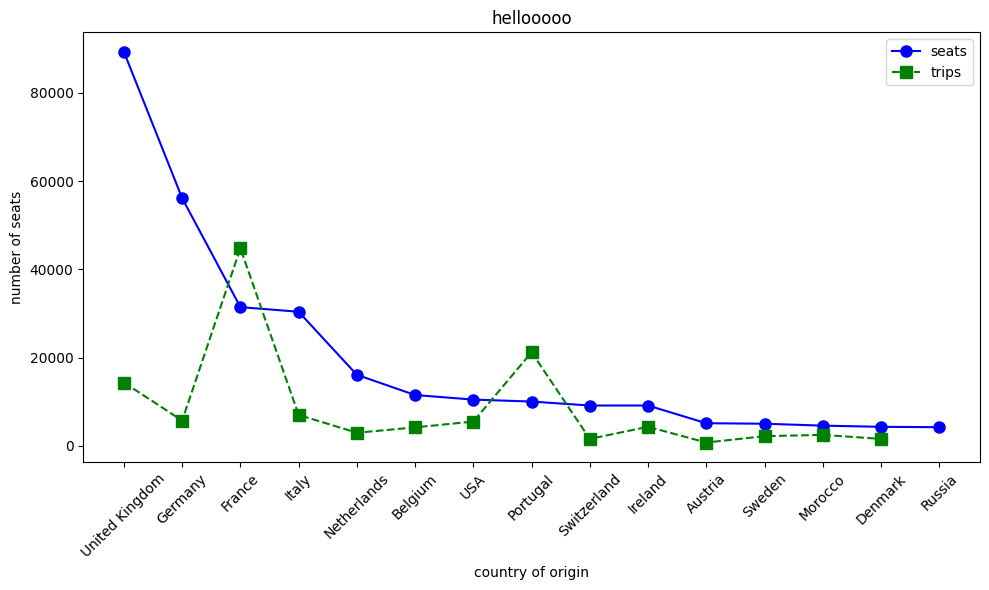

In [72]:
plt.figure(figsize=(10,6))

flights_per_country_incoming_first15=flights_per_country_incoming.head(15)

plt.plot(flights_per_country_incoming_first15["country_origin"],flights_per_country_incoming_first15["seats"],"bo-",label="seats",markersize=8)
plt.plot(flights_per_country_incoming_first15["country_origin"],flights_per_country_incoming_first15["trips"],"gs--",label="trips",markersize=8)

plt.xlabel("country of origin")
plt.ylabel("number of seats")
plt.title("hellooooo")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

In [79]:
trips_abroad[trips_abroad["origin"]=="ES300"]

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
11667,20220923,ES300,Madrid,AE,AE,NaN,airport_MAD,NF,NF,P05*2807908*2807921*None*airport_MAD*01-02*roa...,AE,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
11668,20220923,ES300,Madrid,AE,AE,NaN,airport_MAD,NF,NF,P06*2807901*2807921*None*airport_MAD*01-02*roa...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
11669,20220923,ES300,Madrid,AE,AE,NaN,airport_MAD,NF,NF,P06*2807904*2807921*None*airport_MAD*00-01*roa...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
11670,20220923,ES300,Madrid,AE,AE,NaN,airport_MAD,NF,NF,P10*2807906*2807921*None*airport_MAD*00-01*roa...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
11671,20220923,ES300,Madrid,AE,AE,NaN,airport_MAD,NF,NF,P11*2807905*2807905*None*train_17000*None*road...,AE,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,4,road-train-road-plane,train_17000-train_98305-airport_MAD,train_17000,airport_MAD,international_D,2,1,1,airport_MAD,airport_MAD,airport_MAD,"['rail', 'air']",3.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20044,20220923,ES300,Madrid,UZ,UZ,NaN,airport_MAD,NF,NF,P12*2807911*2807921*None*airport_MAD*00-01*roa...,UZ,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
20045,20220923,ES300,Madrid,VN,VN,NaN,airport_MAD,NF,NF,P06*2807901*2807921*None*airport_MAD*01-02*roa...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
20046,20220923,ES300,Madrid,VN,VN,NaN,airport_MAD,NF,NF,P12*2807901*2807921*None*airport_MAD*00-01*roa...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
20047,20220923,ES300,Madrid,ZA,ZA,NaN,airport_MAD,NF,NF,P15*2807921*2807921*None*airport_MAD*None*road...,AR,2.379425,0.72625,0.295039,0.031057,0.130199,0.037029,2,road-plane,airport_MAD,airport_MAD,airport_MAD,international_D,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
